# Assignment 3 - Denoising

## Emanuele Muzio - 0766230

Esercitazione sul rumore nelle immagini.

I 3 principali task sono:

1. Identificazione del rumore che affligge il nostro data set di immagini tramite istogrammi delle intensità delle immagini grayscale (Gaussiano, Salt-and-Pepper, Poisson) e stima dei parametri di rumore 
2. Ideare una serie di step per la diminuzione del rumore delle immagini (possiamo usare lo spatial filtering o implementare un filtro adattivo motivando le scelte)
3. Fare denoising dell'immagine con i Markov Random Fields. Adatteremo l'algoritmo ICM per allenare un MRF e recuperare l'immagine senza rumore in scala di grigi

E' stato fornito un insieme di 10 immagini (versione originale e versione noisy).

Si dovrà inoltre effettuare una misura della bontà delle soluzioni adottate tramite MSE e PSNR delle coppie di immagini: corrotte e non corrotte, denoised e corrotte. Calcolare questa metrica per entrambe le tecniche.

# 1. Costruzione istogrammi e stime sul rumore

Per il primo step, cominciamo dall'acquizione delle immagin rumorose per l'identificazione del rumore.

Possiamo scegliere un'area "equilibrata" senza variazioni eccessive di intensità di pixel.

In [1]:
import numpy as np
import cv2 as cv
import os
import denoising
from sklearn.metrics import mean_squared_error

# Creazione del dizionario contenente per ogni immagine la strip scelta 
# per l'istogramma, media e dev. std.

noisy_path = 'gr1/Noisy'
strips_path = 'gr1/Strips'
noisy_imgs = os.listdir(noisy_path)
original_path = 'gr1/Original'
original_imgs = os.listdir(original_path)
data = {key: {} for key in noisy_imgs}
imgs = []
original_list = []

# I rumori sono gaussiano impulsivo e poisson

for original_img in original_imgs:
    img = cv.imread(f'{original_path}/{original_img}', cv.IMREAD_GRAYSCALE)
    original_list.append(img)

for noisy_img in noisy_imgs:
    img = cv.imread(f'{noisy_path}/{noisy_img}', cv.IMREAD_GRAYSCALE)
    imgs.append(img)
    # Implementare scelta manuale della strip
    # Per la realizzazione dell'estrazione della strip, le immagini sono state scelte manualmente
    # ritagliando l'area di interesse e salvando le strip ritagliate in una cartella dedicata
    # strip = denoising.getStrip(img)
    strip = cv.imread(f'{strips_path}/{noisy_img}', cv.IMREAD_GRAYSCALE)
    data[noisy_img]["strip"] = strip
    data[noisy_img]["mean"] = np.mean(strip)
    data[noisy_img]["stddev"] = np.std(strip)

Per fare una valutazione sul tipo di rumore effettivo presente nelle immagini, possiamo sia fare delle osservazioni sui grafici ottenuti che andare ad operare, sia aiutarci calcolando media e deviazione standard delle distribuzioni ottenute.

Come riferimento grafico, prendiamo come riferimento i seguenti esempi:

![Gaussiana](gaussian_example.png)
![Salt and pepper](impulsive_example.png)
![Uniforme](poisson_example.png)

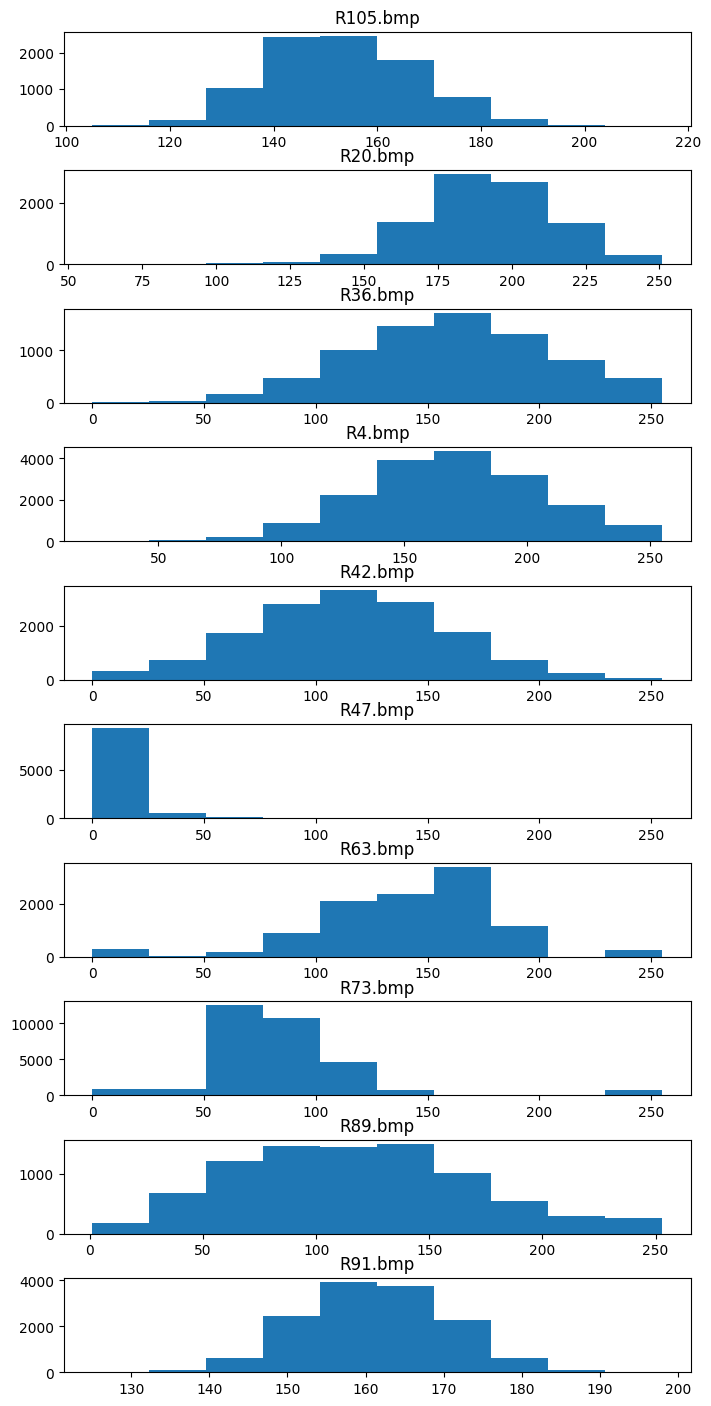

In [2]:
denoising.makeHistograms(data)

| Noisy Img | Noise           |
|-----------|-----------------|
| R105      | Poisson         |
| R20       | Gaussian        |
| R36       | Gaussian        |
| R4        | Gaussian        |
| R42       | Gaussian        |
| R47       | Salt-and-pepper |
| R63       | Salt-and-pepper |
| R73       | Salt-and-pepper |
| R89       | Salt-and-pepper |
| R91       | Gaussian        |

In [3]:
print('|   Img   |   a   |   b   |')
print('|---------|-------|-------|')
for name, _data in data.items():
    m = _data['mean']
    s = _data['stddev']
    print(f'|{name} | {str(round(m, 2))} | {str(round(s, 2))} |')

|   Img   |   a   |   b   |
|---------|-------|-------|
|R105.bmp | 152.85 | 14.15 |
|R20.bmp | 191.19 | 23.7 |
|R36.bmp | 160.62 | 44.07 |
|R4.bmp | 169.81 | 36.04 |
|R42.bmp | 114.89 | 43.65 |
|R47.bmp | 15.46 | 22.53 |
|R63.bmp | 141.3 | 40.42 |
|R73.bmp | 83.85 | 35.9 |
|R89.bmp | 117.3 | 51.48 |
|R91.bmp | 161.32 | 9.18 |


# 2. Riduzione del rumore

Possiamo adesso procedere a fare dei tentativi per ridurre il rumore delle nostre immagini.

Abbiamo la possibilità di sfruttare le informazioni ottenute allo step precedente per orientarci nelle scelte migliori per i tentativi di restauro delle immagini.

In particolare:
- Per le immagini affette da salt-and-pepper noise, è stato sufficiente applicare un filtro mediano e poi, per andare a rifinire alcuni dettagli dell'immagine, applicare dello sharpening (facendo un trade-off con la reintroduzione del rumore in alcune immagini)
- Per le immagini affette da rumore Gaussiano, abbiamo usato la funzione built-in di OpenCV $fastNlMeansDenoising$ con un valore leggermente più alto dello standard di h per aumentare l'efficacia del filtro
- Per le immagini affette da rumore uniforme abbiamo applicato un average filter con kernel di dimensioni 5x5

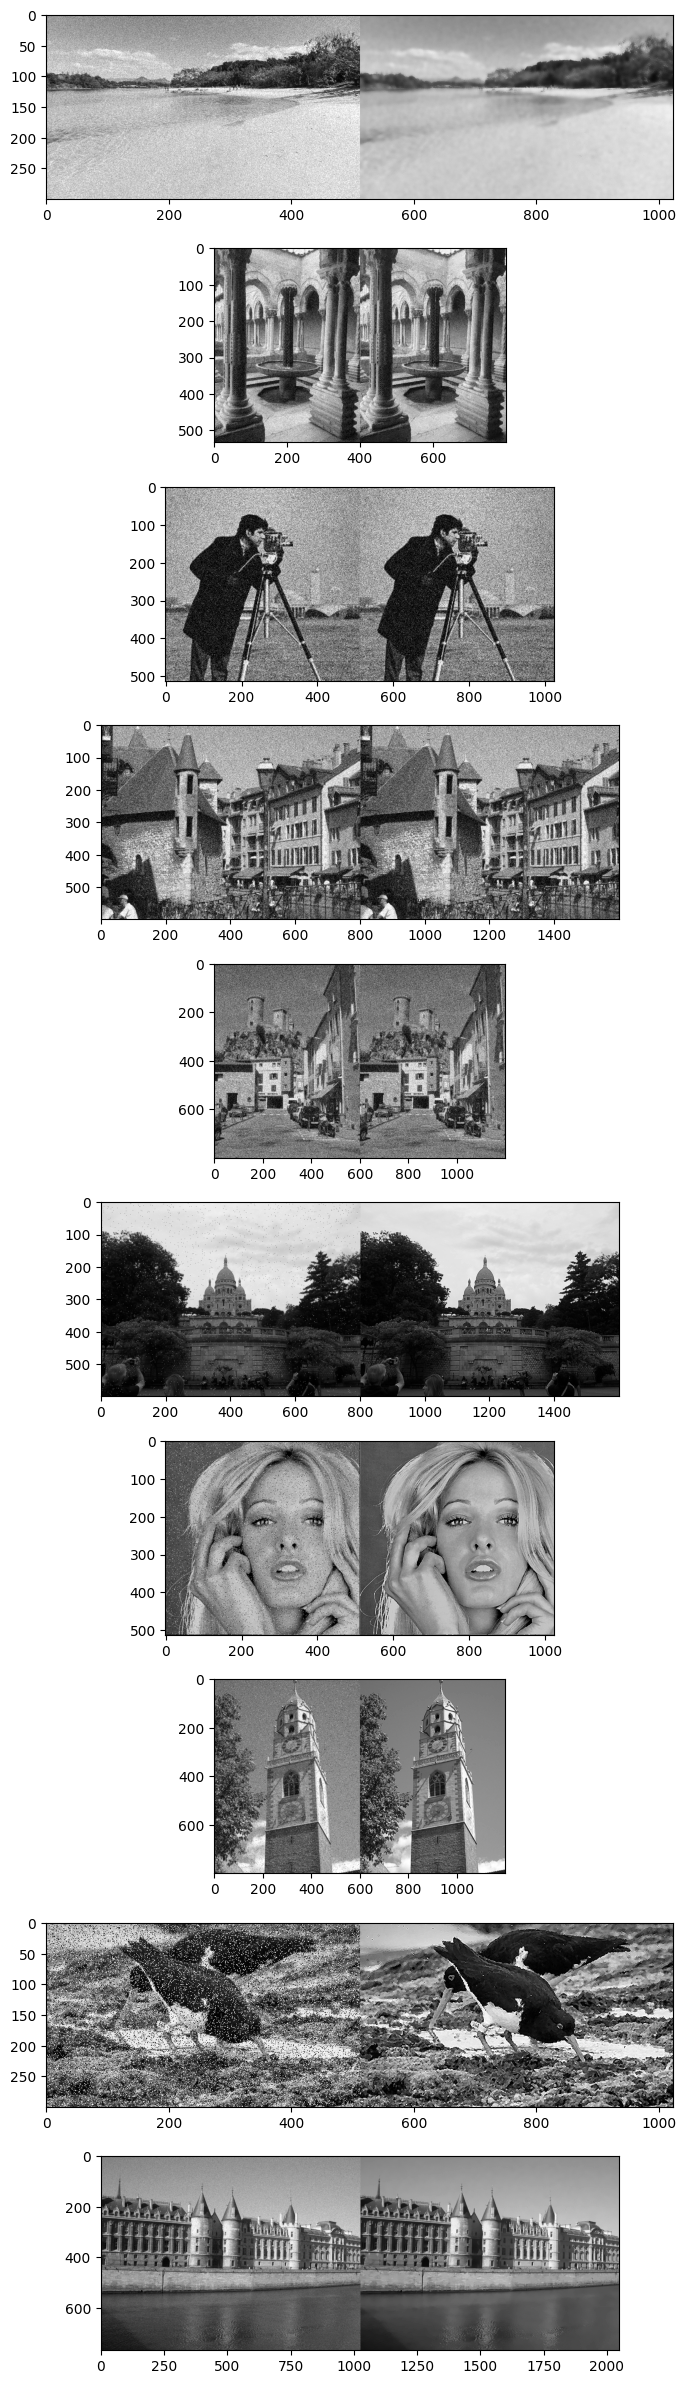

In [4]:
import matplotlib.pyplot as plt

noise_list = [
        'poisson',
        'gaussian',
        'gaussian',
        'gaussian',
        'gaussian',
        'impulsive',
        'impulsive',
        'impulsive',
        'impulsive',
        'gaussian'
]

reduced_imgs = denoising.reduceNoise(noise_list, imgs)
comparison = []
        
for im, img in zip(reduced_imgs, imgs):
    if im is not None:
        stack = np.hstack((img, im))
        comparison.append(stack) 
    else:
        comparison.append(im)
        
fig, axes = plt.subplots(len(imgs), 1, figsize=(7, 24))
fig.tight_layout()
    
for i in range(len(imgs)):  
    if comparison[i] is not None:
        label = noisy_imgs[i]
        cv.imwrite(f'reduced/{label}', reduced_imgs[i])
        axes[i].imshow(comparison[i], cmap="gray")

Dai risultati ottenuti alcune immagini beneficiano maggiormente delle operazioni a cui sono state sottoposte rispetto ad altre. 

I possibili motivi:

- Classificazione scorretta nella prima fase, per cui sarebbe ideale rivedere la scelta della strip oppure intraprendere altre strade, come l'aggiunta dei 3 tipi di rumore all'immagine originale seguita dall'uso di un classificatore. Questo tuttavia rappresenterebbe un caso altamente ideale, non avendo sempre a disposizione l'originale senza rumore
- Immagine originale eccessivamente rumorosa, che porterebbe in caso di classificazione corretta a risultati visibilmente miglior su alcune immagini rispetto ad altre (in quanto aventi problematiche meno consistenti)

# 3. Denoising delle immagini

Procediamo infine a fare denoising delle immagini con rumore ridotto partendo dai MRF e applicando un algoritmo ICM.

I Markov Random Fields sono modelli per la stima probabilistica, che mirano a stimare (nel caso delle immagini) i pixel sconosciuti x a partire dalle immagini conosciute y.

Possiamo formulare il problema come un problema di minimizzazione dell'energia, in cui:

$E(x,y) = E_D(x,y) + E_P(x)$

Questo problema di minimizzazione si può risolvere con un algoritmo ICM, ribaltando gli stati uno alla volta se questo ribaltamento porta ad un'energia minore, operazione per cui troviamo i minimi locali con la discesa del gradiente. Possiamo applicare l'algoritmo di ICM in caso di immagini binarie e verificare i risultati, adattandolo al caso delle immagini in gray scale.

Per l'adattamento si è scelto di fare dei tentativi diversi per la sostituzione dei pixel, andando a provare valori da 0 a 255 a intervalli da 32.

Il risultato è stato salvate in un file con il pacchetto pickle in quanto, per una decina di immagini e 3 iterazioni massime dell'algoritmo, a causa delle molte iterazioni l'esecuzione è durata oltre 10 minuti.

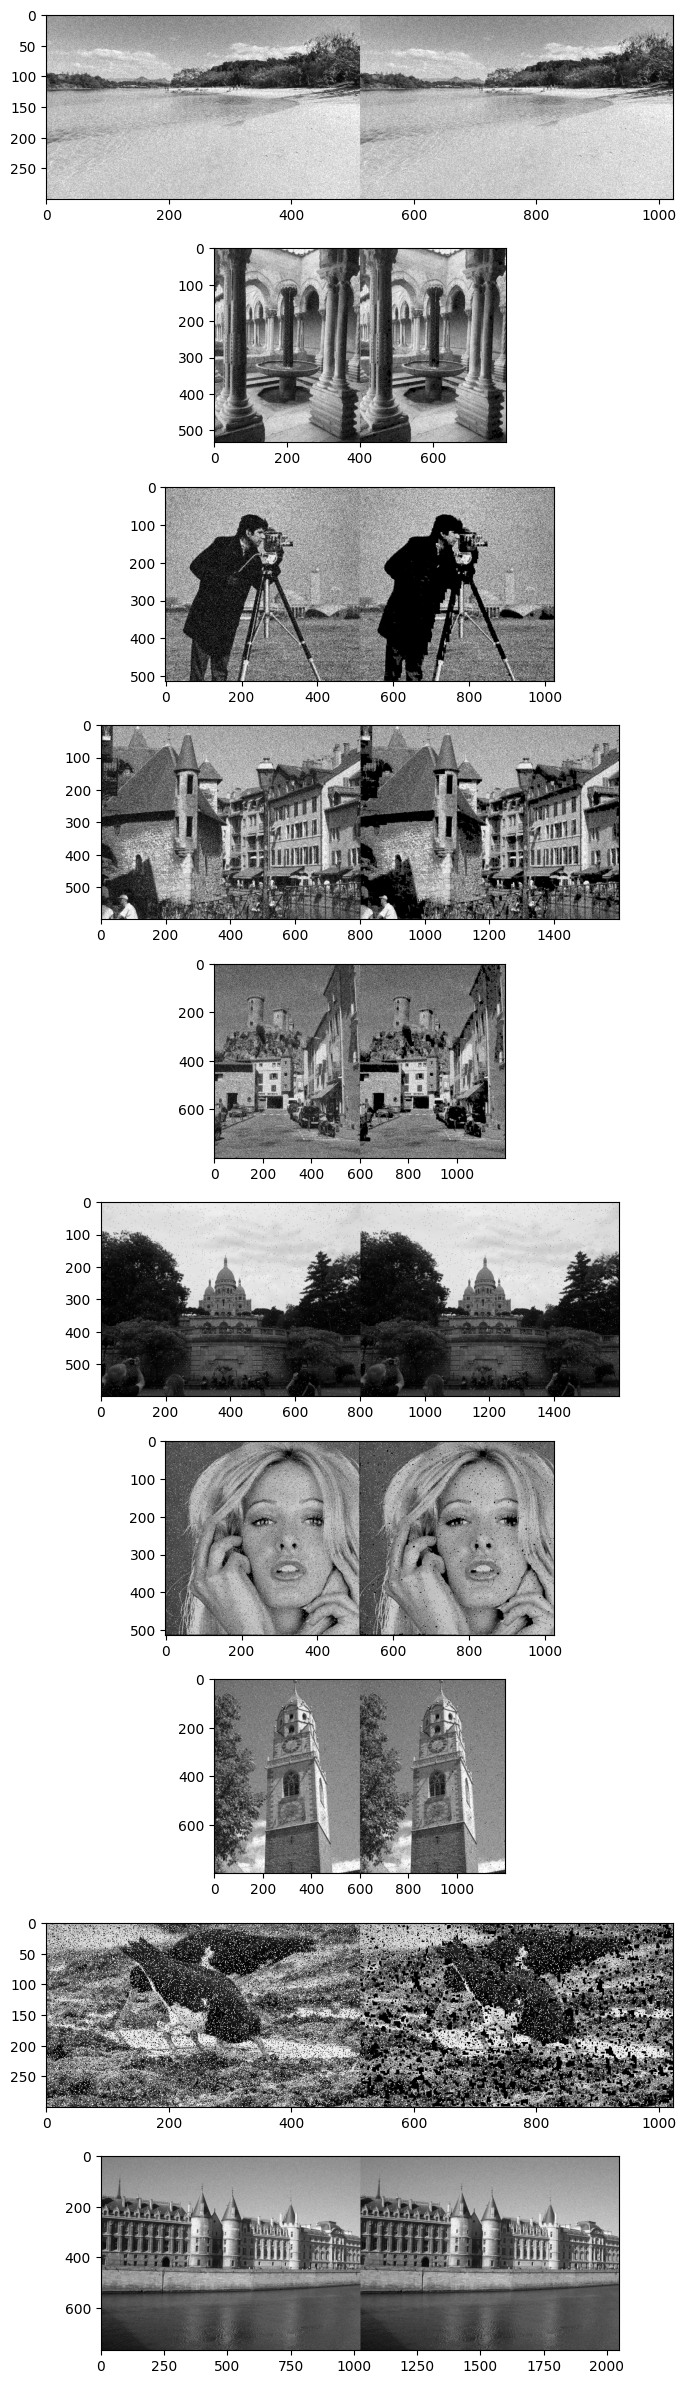

In [5]:
import pickle

denoised = []

if os.path.exists('icm'):
    file = open('icm', 'rb')
    denoised = pickle.load(file)
    file.close()
else:
    for img in imgs:
        im = denoising.ICM(img, 3)
        denoised.append(im)
    file = open('icm','wb')
    pickle.dump(denoised, file)
    file.close()
    
for i in range(len(denoised)):
    denoised[i] = denoised[i][1:-1,1:-1]
    
denoised_comparison = []
    
for den, img in zip(denoised, imgs):
    stack = np.hstack((img, den))
    denoised_comparison.append(stack)
            
fig, axes = plt.subplots(len(imgs), 1, figsize=(7, 24))
fig.tight_layout()

for i in range(len(imgs)):  
    label = noisy_imgs[i]
    cv.imwrite(f'denoised/{label}', reduced_imgs[i])
    axes[i].imshow(denoised_comparison[i], cmap="gray")

Procediamo infine a confrontare i risultati ottenuti tramite le due tecniche di riduzione del rumore usando come metriche quantitative MSE e PSNR.

In [9]:
for i in range(len(imgs)):  
    label = original_imgs[i]
    mse_orig_corr = mean_squared_error(original_list[i], imgs[i])
    psnr_orig_corr = cv.PSNR(original_list[i], imgs[i])
    
    mse_den_corr = mean_squared_error(denoised[i], imgs[i])
    psnr_den_corr = cv.PSNR(denoised[i], imgs[i])
    
    print(f'Img: {label}\n MSE original-corrupted: {str(round(mse_orig_corr, 2))}\n MSE denoised-corrupted: {str(round(mse_den_corr, 2))}\n PSNR original-corrupted: {str(round(psnr_orig_corr, 2))}\n PSNR denoised-corrupted: {str(round(psnr_orig_corr, 2))}\n')

Img: 105.jpg
 MSE original-corrupted: 71.07
 MSE denoised-corrupted: 0.39
 PSNR original-corrupted: 25.7
 PSNR denoised-corrupted: 25.7

Img: 20.jpg
 MSE original-corrupted: 84.39
 MSE denoised-corrupted: 1.13
 PSNR original-corrupted: 23.08
 PSNR denoised-corrupted: 23.08

Img: 36.bmp
 MSE original-corrupted: 103.87
 MSE denoised-corrupted: 17.31
 PSNR original-corrupted: 15.83
 PSNR denoised-corrupted: 15.83

Img: 4.JPG
 MSE original-corrupted: 100.46
 MSE denoised-corrupted: 11.14
 PSNR original-corrupted: 17.39
 PSNR denoised-corrupted: 17.39

Img: 42.bmp
 MSE original-corrupted: 103.28
 MSE denoised-corrupted: 8.5
 PSNR original-corrupted: 15.57
 PSNR denoised-corrupted: 15.57

Img: 47.bmp
 MSE original-corrupted: 1.05
 MSE denoised-corrupted: 0.19
 PSNR original-corrupted: 24.14
 PSNR denoised-corrupted: 24.14

Img: 63.bmp
 MSE original-corrupted: 5.39
 MSE denoised-corrupted: 1.57
 PSNR original-corrupted: 18.62
 PSNR denoised-corrupted: 18.62

Img: 73.bmp
 MSE original-corrupte